#Kolmogorov-Arnold Network

KAN, or Kolmogorov-Arnold Networks, are a novel deep learning architecture that embraces structured external knowledge sources into neural networks to improve the understanding and reasoning of complex data. Models can better infer more accurate and contextually enriched insights that happen to be quite valuable in AI applications such as natural language processing, recommendation systems, etc.

The research behind this work, titled "Knowledge Graphs: Enhancing Neural Networks Through Structured Reasoning" ([arXiv:2404.19756](https://arxiv.org/abs/2404.19756)), explores the concept of knowledge graphs and neural networks. It emphasizes how external knowledge bridges this gap in machine learning models so they can reason more meaningfully and deliver better results across a wide scale of tasks.

In [1]:
!pip install pykan

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.6/77.6 kB 1.5 MB/s eta 0:00:00


In [2]:
from kan import *
torch.set_default_dtype(torch.float64)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

# create a KAN: 2D inputs, 1D output, and 5 hidden neurons. cubic spline (k=3), 5 grid intervals (grid=5).
model = KAN(width=[2,5,1], grid=3, k=3, seed=42, device=device)

cpu
checkpoint directory created: ./model
saving model version 0.0


 Creating a dataset

In [3]:
import random
import torch
import numpy as np
from kan import KAN

def generate_key_exchange_data(num_samples):
    data = []
    for _ in range(num_samples):
        # Generate random keys within uint64 range
        party_A_key = random.getrandbits(64)  # Use 64 bits instead of 128
        party_B_key = random.getrandbits(64)  # Use 64 bits instead of 128
        # XOR key exchange simulation
        exchange = party_A_key ^ party_B_key
        data.append((party_A_key, party_B_key, exchange))
    return data

# Generate the dataset
num_samples = 10000
key_exchange_data = generate_key_exchange_data(num_samples)

# Convert to numpy arrays, specifying dtype as uint64
X = np.array([(a, b) for a, b, _ in key_exchange_data], dtype=np.uint64)  # Specify dtype here
y = np.array([e for _, _, e in key_exchange_data], dtype=np.uint64)  # Specify dtype here

# Convert to PyTorch tensors
X_tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.float32).unsqueeze(1)

# Normalize the data
X_tensor = (X_tensor - X_tensor.mean()) / X_tensor.std()
y_tensor = (y_tensor - y_tensor.mean()) / y_tensor.std()

# Create a dataset dictionary
dataset = {
    'train_input': X_tensor[:8000],
    'train_label': y_tensor[:8000],
    'val_input': X_tensor[8000:9000],
    'val_label': y_tensor[8000:9000],
    'test_input': X_tensor[9000:],
    'test_label': y_tensor[9000:],
}

# Initialize and train KAN model
# The original parameters 'n_var', 'n_layers', and 'n_nodes' are not part of the KAN constructor.
# Instead, use 'width', 'grid', 'k', 'seed', and 'device' as in your previous usage.
kan_model = KAN(width=[2, 5, 1], grid=3, k=3, seed=42, device=device)

# Train the model (you'll need to implement this part based on KAN's API)
# kan_model.train(dataset['train_input'], dataset['train_label'])

# Evaluate the model
# test_predictions = kan_model.predict(dataset['test_input'])
# Calculate and print evaluation metrics

print("Dataset shapes:")
print(f"Train: {dataset['train_input'].shape}, {dataset['train_label'].shape}")
print(f"Validation: {dataset['val_input'].shape}, {dataset['val_label'].shape}")
print(f"Test: {dataset['test_input'].shape}, {dataset['test_label'].shape}")

checkpoint directory created: ./model
saving model version 0.0
Dataset shapes:
Train: torch.Size([8000, 2]), torch.Size([8000, 1])
Validation: torch.Size([1000, 2]), torch.Size([1000, 1])
Test: torch.Size([1000, 2]), torch.Size([1000, 1])


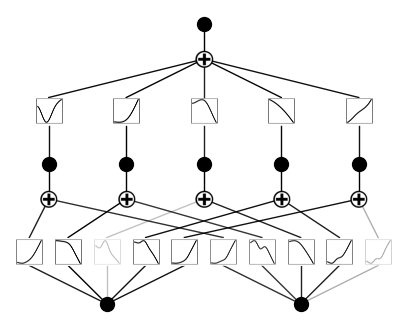

In [4]:
# plot KAN at initialization
model(dataset['train_input']);
model.plot()

KAN Model Training

In [ ]:
import torch
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# Ensure PyTorch is using double precision
torch.set_default_dtype(torch.float64)

def train_kan_model(model, dataset, num_epochs=100, batch_size=32, learning_rate=0.001):
    # Prepare data loaders
    train_loader = DataLoader(TensorDataset(dataset['train_input'].double(), dataset['train_label'].double()),
                              batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(TensorDataset(dataset['val_input'].double(), dataset['val_label'].double()),
                            batch_size=batch_size)

    # Define loss function and optimizer
    criterion = torch.nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # Training loop
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(model.device), labels.to(model.device)

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Backward pass and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * inputs.size(0)

        # Validation
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(model.device), labels.to(model.device)
                outputs = model(inputs)
                val_loss += criterion(outputs, labels).item() * inputs.size(0)

        train_loss /= len(train_loader.dataset)
        val_loss /= len(val_loader.dataset)

        print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')

    return model

# Convert dataset to double precision
dataset = {key: value.double() for key, value in dataset.items()}

# Train the model
trained_model = train_kan_model(kan_model, dataset)

# Evaluate the model on the test set
test_loader = DataLoader(TensorDataset(dataset['test_input'].double(), dataset['test_label'].double()), batch_size=32)
test_loss = 0.0
trained_model.eval()
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(trained_model.device), labels.to(trained_model.device)
        outputs = trained_model(inputs)
        test_loss += torch.nn.MSELoss()(outputs, labels).item() * inputs.size(0)

test_loss /= len(test_loader.dataset)
print(f'Test Loss: {test_loss:.4f}')

Epoch 1/100, Train Loss: 0.8590, Val Loss: 0.5068
Epoch 2/100, Train Loss: 0.3825, Val Loss: 0.3086
Epoch 3/100, Train Loss: 0.3268, Val Loss: 0.2965
Epoch 4/100, Train Loss: 0.3058, Val Loss: 0.2722
Epoch 5/100, Train Loss: 0.2624, Val Loss: 0.2176
Epoch 6/100, Train Loss: 0.2141, Val Loss: 0.1865
Epoch 7/100, Train Loss: 0.1926, Val Loss: 0.1746
Epoch 8/100, Train Loss: 0.1837, Val Loss: 0.1685
Epoch 9/100, Train Loss: 0.1774, Val Loss: 0.1658
Epoch 10/100, Train Loss: 0.1731, Val Loss: 0.1625
Epoch 11/100, Train Loss: 0.1698, Val Loss: 0.1593
Epoch 12/100, Train Loss: 0.1669, Val Loss: 0.1574
Epoch 13/100, Train Loss: 0.1640, Val Loss: 0.1565
Epoch 14/100, Train Loss: 0.1616, Val Loss: 0.1552
Epoch 15/100, Train Loss: 0.1598, Val Loss: 0.1513
Epoch 16/100, Train Loss: 0.1581, Val Loss: 0.1486
Epoch 17/100, Train Loss: 0.1564, Val Loss: 0.1497
Epoch 18/100, Train Loss: 0.1552, Val Loss: 0.1504
Epoch 19/100, Train Loss: 0.1540, Val Loss: 0.1476
Epoch 20/100, Train Loss: 0.1527, Val Lo

KAN Model Evaluation

In [ ]:
import torch
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

def evaluate_model(model, test_input, test_label):
       model.eval()
       with torch.no_grad():
           predictions = model(test_input.to(model.device)).cpu().numpy()
           true_values = test_label.cpu().numpy()

       mse = mean_squared_error(true_values, predictions)
       mae = mean_absolute_error(true_values, predictions)
       r2 = r2_score(true_values, predictions)

       print(f"Mean Squared Error: {mse:.4f}")
       print(f"Mean Absolute Error: {mae:.4f}")
       print(f"R-squared Score: {r2:.4f}")

       return mse, mae, r2

   # Assuming dataset['test_input'] and dataset['test_label'] exist
mse, mae, r2 = evaluate_model(trained_model, dataset['test_input'], dataset['test_label'])

Mean Squared Error: 0.1202
Mean Absolute Error: 0.2632
R-squared Score: 0.8749
